<a href="https://colab.research.google.com/github/AlenaPotato/pet_projects/blob/main/hh_parsing_and_basic_nlp/hh_parsing_and_basic_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сейчас непростое время. В такие времена всегда надо быть наготове: могут понадобится деньги на лечение так невовремя разболевшегося зуба; лучший друг купит билеты в  Диснейленд на вас двоих с вылелетом завтра; или понадобиться резко менять работу. Последнее для меня актуально. </br></br>
Чтобы понять, что сейчас происходит на рынке труда, я хочу изучить вакансии с сайта hh.ru. Но исследовать вакансии я буду при помощи своих навыков дата аналитика. </br></br>
Через анализ данных я хочу понять следующие вещи:
- какой опыт я должна иметь для разного уровня работы,
- какими компетенциями я должна обладать как дата аналитик,
- увидеть стороны, над которыми надо поработать,
- понять требования по образованию и опыту работы,
- найти компании, которые хантят больше всего аналитиков,
- оценить, в какую сферу нужно подаваться.


Для начала начну с банального - импортирую необходимые библиотеки.

In [2]:
# for data importing
import requests
import pandas as pd
import json
import time

# for data analytics
import seaborn as sns
sns.set_palette("pastel")
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import numpy as np

# other packages
import warnings
warnings.filterwarnings('ignore')

# Парсер

Для начала мне необходимо скачать данные. Данные я буду парсить при помощи HeadHunter API. </br></br>
Политика HeadHunter'а ограничивает количество данных, которые я могу скачать. В целом есть пути обхода этих ограничений, но поскольку мой проект - это "проба пера" некоторых новых для меня технологий, то мне предлагаемого количества данных будет вполне достаточно. </br></br>
Ввиду того, что через HeadHunter API скачиваются последние и свежайшие данные (если иного не указано в самом get запросе), то для стабильности моей аналитики полученный датасет я сохранила. Код, при помощи которого я парсила данные, представлен ниже. В дальнейшем я буду работать только с предварительно скаченными данными.

In [3]:
# флаг для надёжности
parse = 0

if parse:
  url = 'https://api.hh.ru/vacancies'
  vacancies = ['Аналитик', 'Аналитик данных', 'Аналитик Данных', 'Дата аналитик', 'Дата Аналитик', 'Data Analyst', "Data analyst"]
  data = pd.DataFrame()

  for page in range(0, 20):
    for job in vacancies:
      # Reference for GET request parameters
      params = {'text': f'NAME:{job}',
                'page': page,
                'area': 113,
                'per_page': 100
                }
      req = requests.get(url, params)
      dictr = req.json()

      new_data = pd.DataFrame.from_dict(dictr['items'])
      req.close()
      data = pd.concat([data, new_data], ignore_index=True)

      time.sleep(0.25)

In [4]:
if parse:
  l = []
  for col in data.columns:
    temp = data[col].apply(pd.Series)

    if temp.shape[1]==1:
      temp.rename(columns={0:col}, inplace=True)
    else:
      data = pd.concat([data, temp], axis=1, sort=False)
      data.drop(columns=col, inplace=True)

    l.append(temp)

  print('Data preparation is completed')

In [5]:
data = pd.read_excel('/content/test.xlsx')
print(data.shape)

(7138, 59)


In [6]:
print(data.published_at.min())
print(data.published_at.max())

2023-11-25T19:56:25+0300
2023-12-25T14:44:28+0300


В анализируемый период вошли данные почти за целый месяц.

# EDA /РАД

## Изучение пропусков

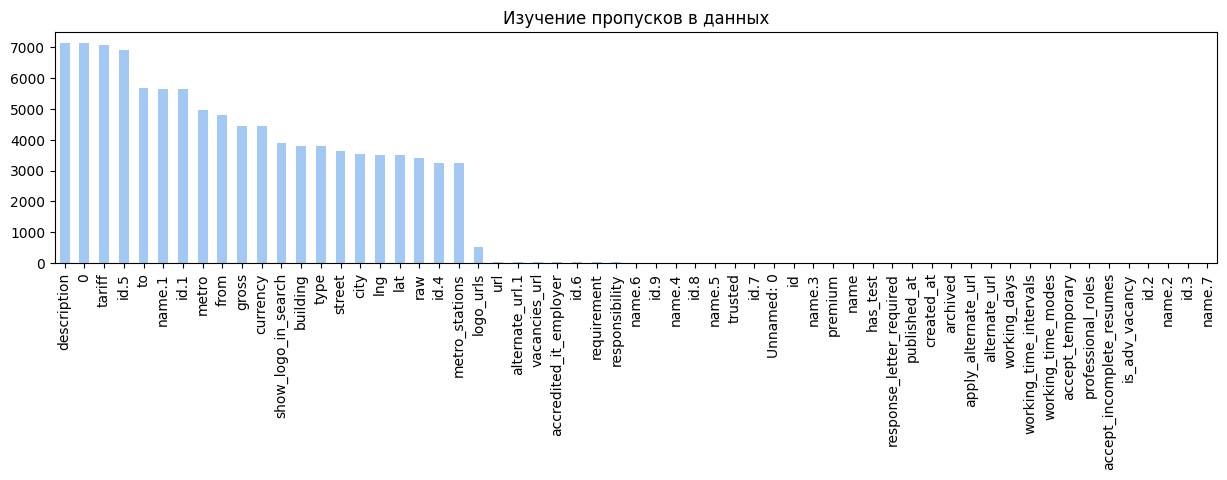

In [7]:
data.isna().sum().sort_values(ascending=False).plot(kind='bar', figsize=(15, 3))
plt.title('Изучение пропусков в данных')
plt.show()

Местами пропуски составляют свыше 20%. Благо пропуски в этих переменных для моей аналитики не критичны. </br></br>
Местами в интересующих меня колонках присутсвуют пропуски. Но это не аномалия - многие вакансии заполняются неполностью, как и многие резюме.

## Какие вакансии попали

<Axes: ylabel='None'>

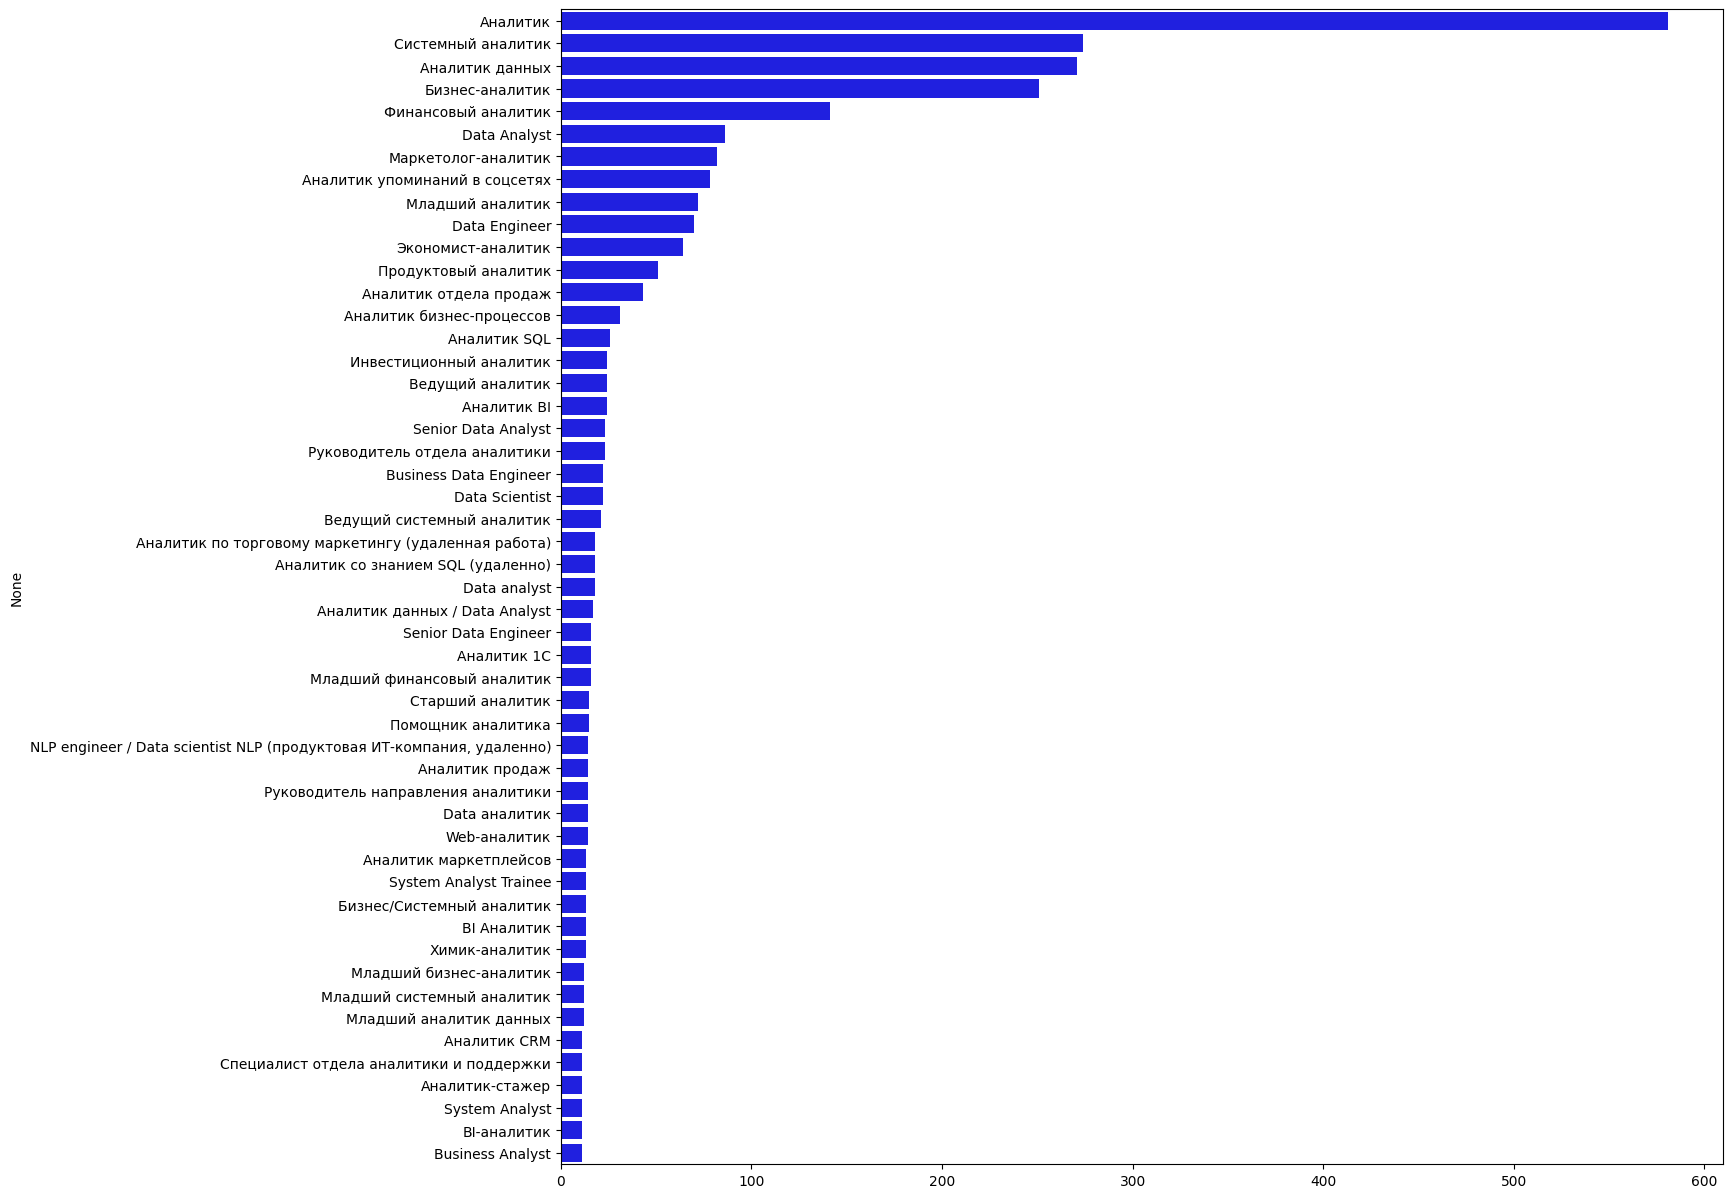

In [8]:
temp = data.iloc[:, 3].value_counts()

plt.figure(figsize=(15,15))
sns.barplot(x=temp[temp > 10].values, y=temp[temp > 10].index, orient='h', color="b")

Можно заметить, что вакансий аналитиков данных не так то уж и много. Хотя в целом разнопрофильные аналитики очень востребованны.


## В какое время дня публиковались вакансии

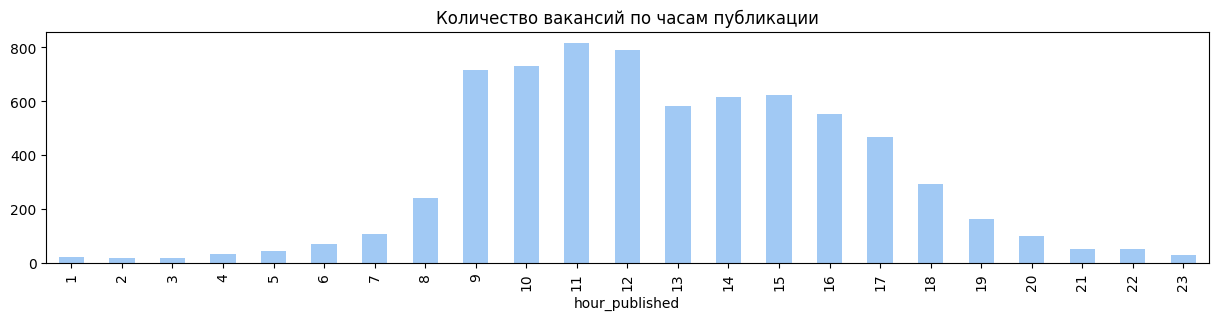

In [9]:
data['published_at'] = pd.to_datetime(data.published_at)
data['hour_published'] = data.published_at.dt.hour
data.groupby('hour_published').count()['name'].plot(kind='bar', figsize=(15,3))
plt.title("Количество вакансий по часам публикации")
plt.show()

Больше всего вакансий опубликовано между 9 и 12 часами. После обеда тоже наблюдается активность, но немного меньшая, чем в первой половине дня.




## Опыт работы - важен?

In [10]:
data['city_status'] = 'small city'
data.loc[(data["city"] == 'Москва'), "city_status"] = 'capital'
data.loc[data.city.isin(['Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Казань', 'Нижний Новгород', 'Челябинск', 'Красноярск', 'Самара', 'Уфа',
                         'Ростов-на-Дону', 'Омск', 'Краснодар', 'Воронеж', 'Волгоград', 'Пермь']), "city_status"] = 'large city'


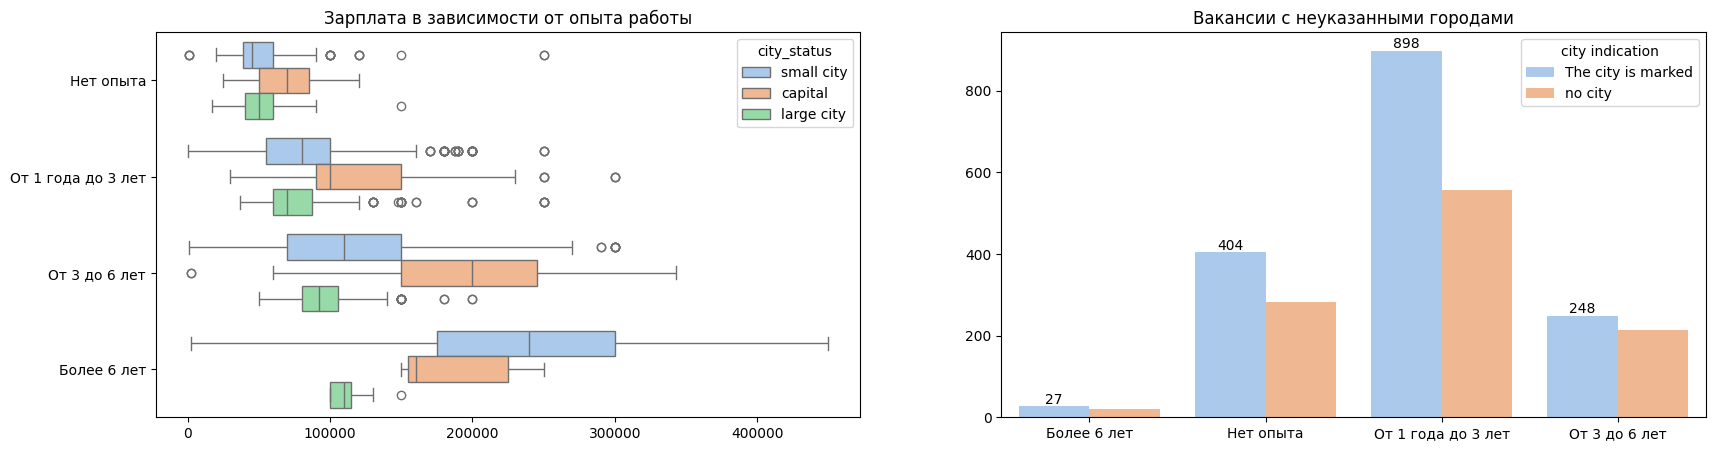

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.boxplot(data=data[data['from']>0], x='from', y='name.6', hue='city_status', ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Зарплата в зависимости от опыта работы')

data['city indication'] = 0
data.loc[data[data.city.isna()==True].index, "city indication"] = 'no city'
data.loc[data['city indication']==0, "city indication"] = 'The city is marked'


temp = data[data.currency=='RUR'].groupby(['name.6', 'city indication'], as_index=False).count().iloc[:,:3]
sns.barplot(data=temp, x='name.6', y=temp.iloc[:,-1], hue='city indication', estimator="sum", ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.bar_label(ax2.containers[0], fontsize=10)
ax2.set_title('Вакансии с неуказанными городами')
plt.show()

Почти у половины вакансий не указан город работы. Больше всего требуется специалисты с небольшим опытом работы ("от 1 года до 3х лет") - их 56%. Меньше всего требуется опытных специалистов (более 6 лет) - таких вакансий едва наберётся 2%.
- Специалисты без опыта в среднем получают чуть больше в столице.
- Специалисты с наличием опыта работы ("от 1 года до 3х лет" и "От 3 до 6 лет") так же в среднем получают чуть больше в столице.
- Специалисты с большим опытом работы в маленьких городах, внезапно, в среднем получают больше, чем в крупных и средних городах.

## А в IT платят больше?

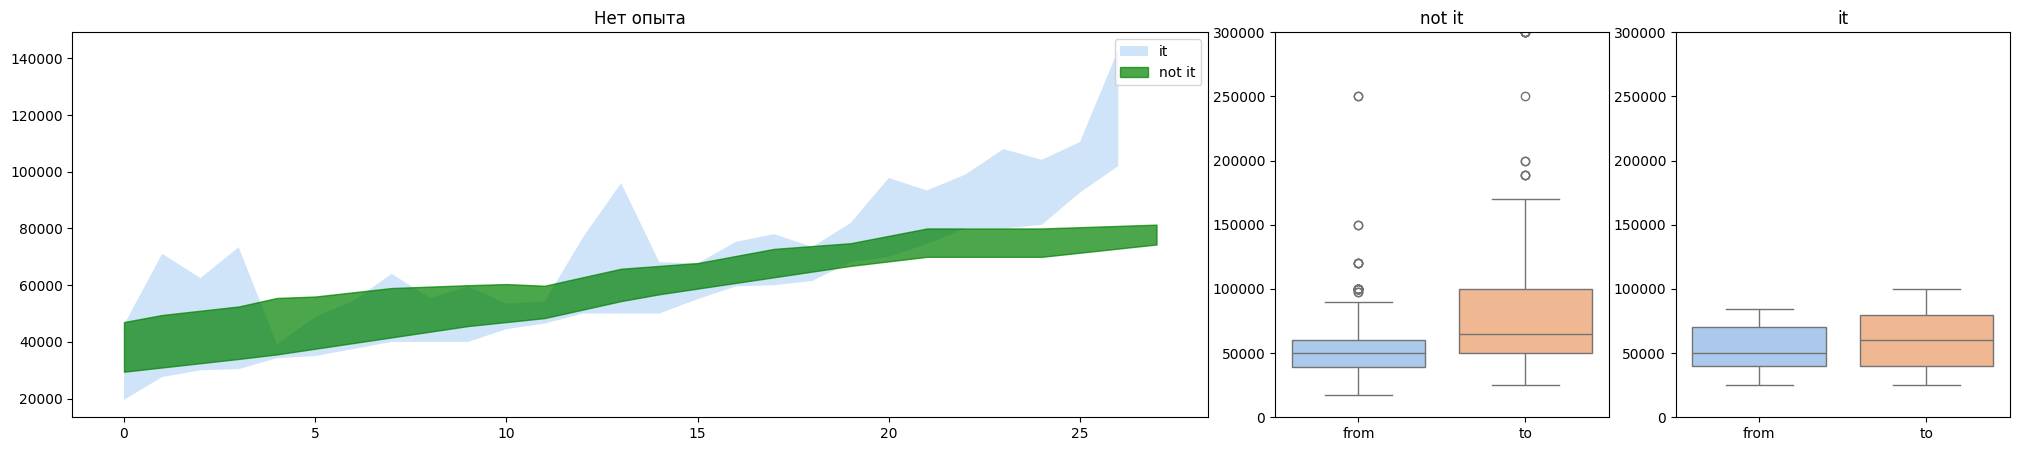

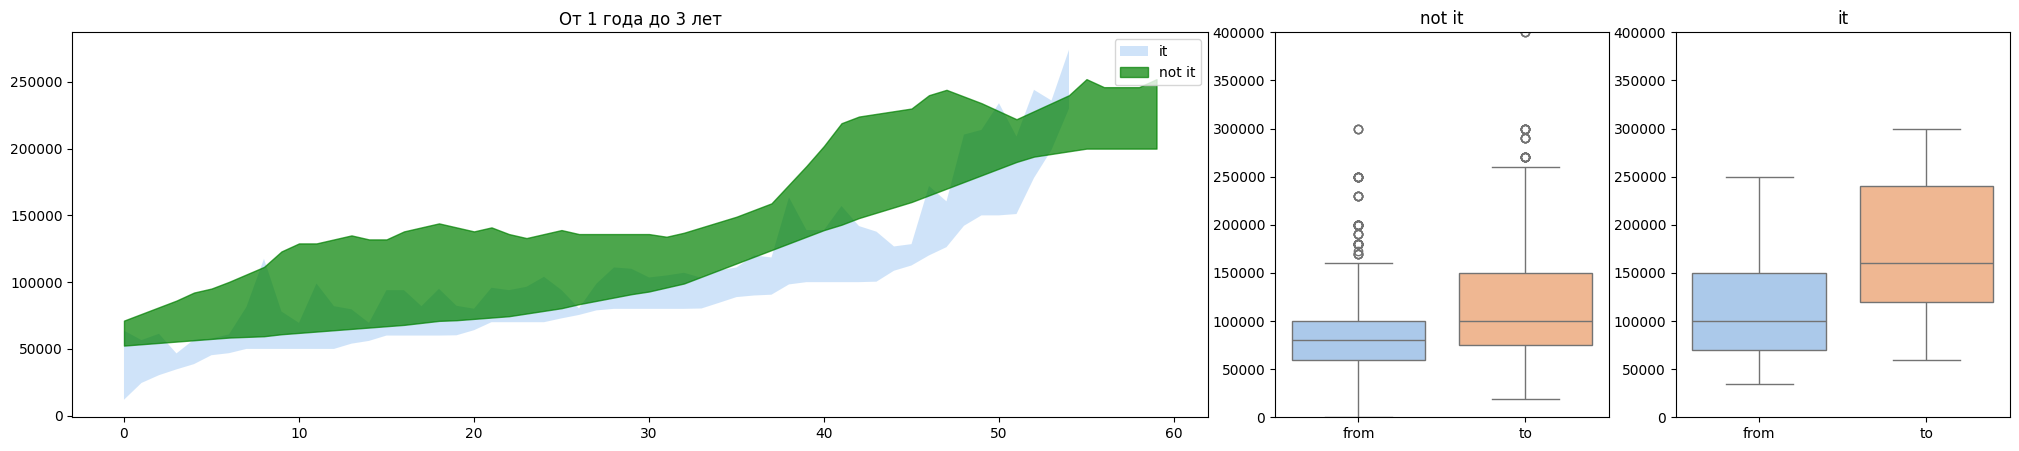

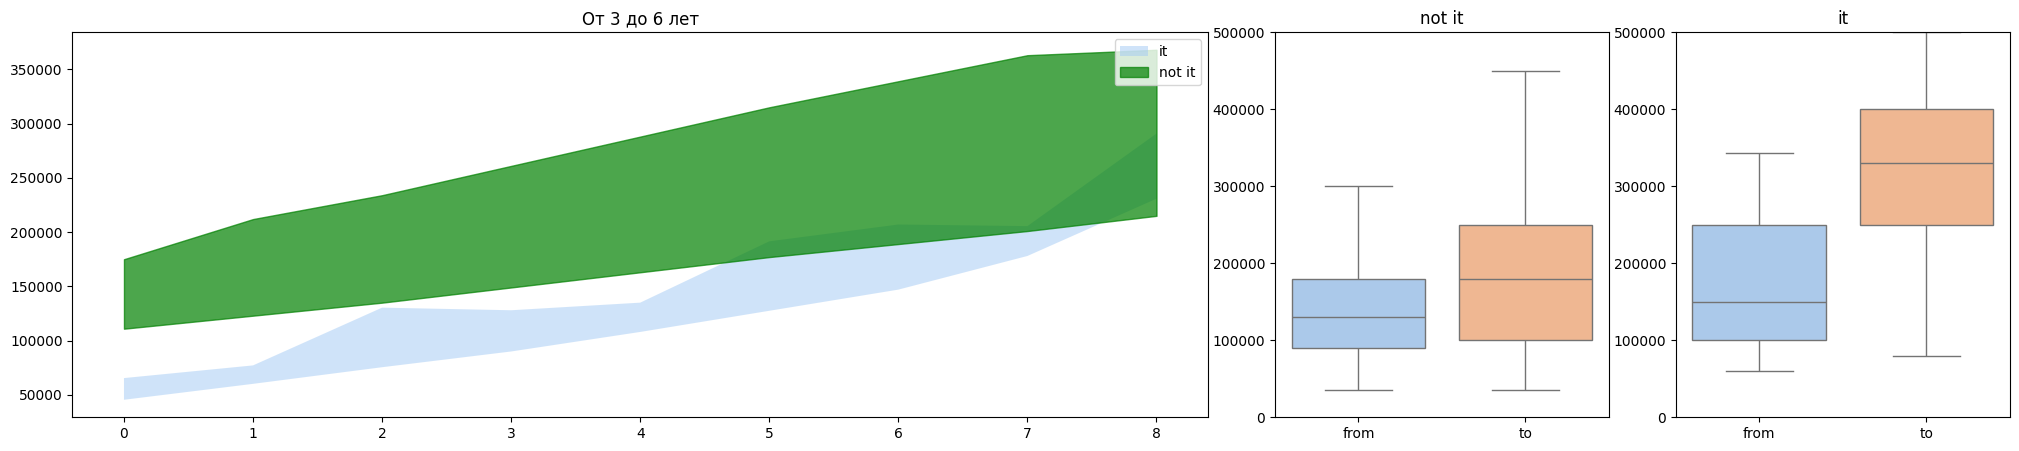

Для категории Более 6 лет мало данных


In [15]:
new_df = []

not_it = data[(data['accredited_it_employer']==0)&(data['currency']=='RUR')][['from', 'to', 'name.6']]
it = data[(data['accredited_it_employer']==1)&(data['currency']=='RUR')][['from', 'to', 'name.6']]

for i in data['name.6'].unique():
  for dataset in [not_it, it]:
    df = dataset[dataset['name.6']==i]
    df.dropna(inplace=True)
    df.sort_values(by='from', inplace=True)
    df.reset_index(drop=True, inplace=True)

    new_df.append(df.rolling(10).mean().dropna().reset_index(drop=True))

  try:
    a = new_df[-2].iloc[::int(new_df[-2].shape[0]/new_df[-1].shape[0])+1] # it
    a = a.reset_index(drop=True)
    b = new_df[-1] # not it


    fig = plt.figure(figsize=(25,5))
    spec = fig.add_gridspec(ncols=5, nrows=1)
    ax1 = fig.add_subplot(spec[0, :3])

    plt.fill_between(a.index, a['from'], a['to'], alpha=0.5, label='it')
    plt.fill_between(b.index, b['from'], b['to'], color='green', alpha=0.7, label='not it')
    plt.legend()
    ax1.set_title(i)

    temp = data[(data['name.6']==i)&(data['currency']=='RUR')][['from','to', 'accredited_it_employer']]

    ax2 = fig.add_subplot(spec[0, 3:4])
    sns.boxplot(data=temp[temp['accredited_it_employer']==0][['from','to']])
    ax2.set_ylim([temp.min().min(),
                  temp.max().max()])
    ax2.set_title('not it')

    ax3 = fig.add_subplot(spec[0, 4:5])
    sns.boxplot(data=temp[temp['accredited_it_employer']==1][['from','to']], ax=ax3)
    ax3.set_ylim([temp.min().min(),
                  temp.max().max()])
    ax3.set_title('it')

    plt.show()
  except:
    print(f'Для категории {i} мало данных')


Судя по боксплотам, средняя зарплатная вилка в IT выше. Но для не-IT сектора много вылетов - это позволяет уравнять шансы на высокую оплату. </br></br>
Для неопытных сотрудников работа в IT на первое время, вероятно, может приносить больший доход, но с ростом опыта труд начинает дороже оцениваться в не-IT сфере.</br></br>
Возможно, отсутсвие разницы как таковой (на первый взгляд) связано с тем фактом, что в 2022-2023 произошёл отток IT-специалистов из РФ и началось замещение мидловских вакансий джуновскими и тд., сопровождающееся падением зарплатной вилки. Из-за этого визуально зарплаты в IT сфере стали меньше.

## Компании

Обычный работодатель предоставляет 85.15 % вакансий
Аккредитованный ит-работодатель предоставляет 14.29 % вакансий


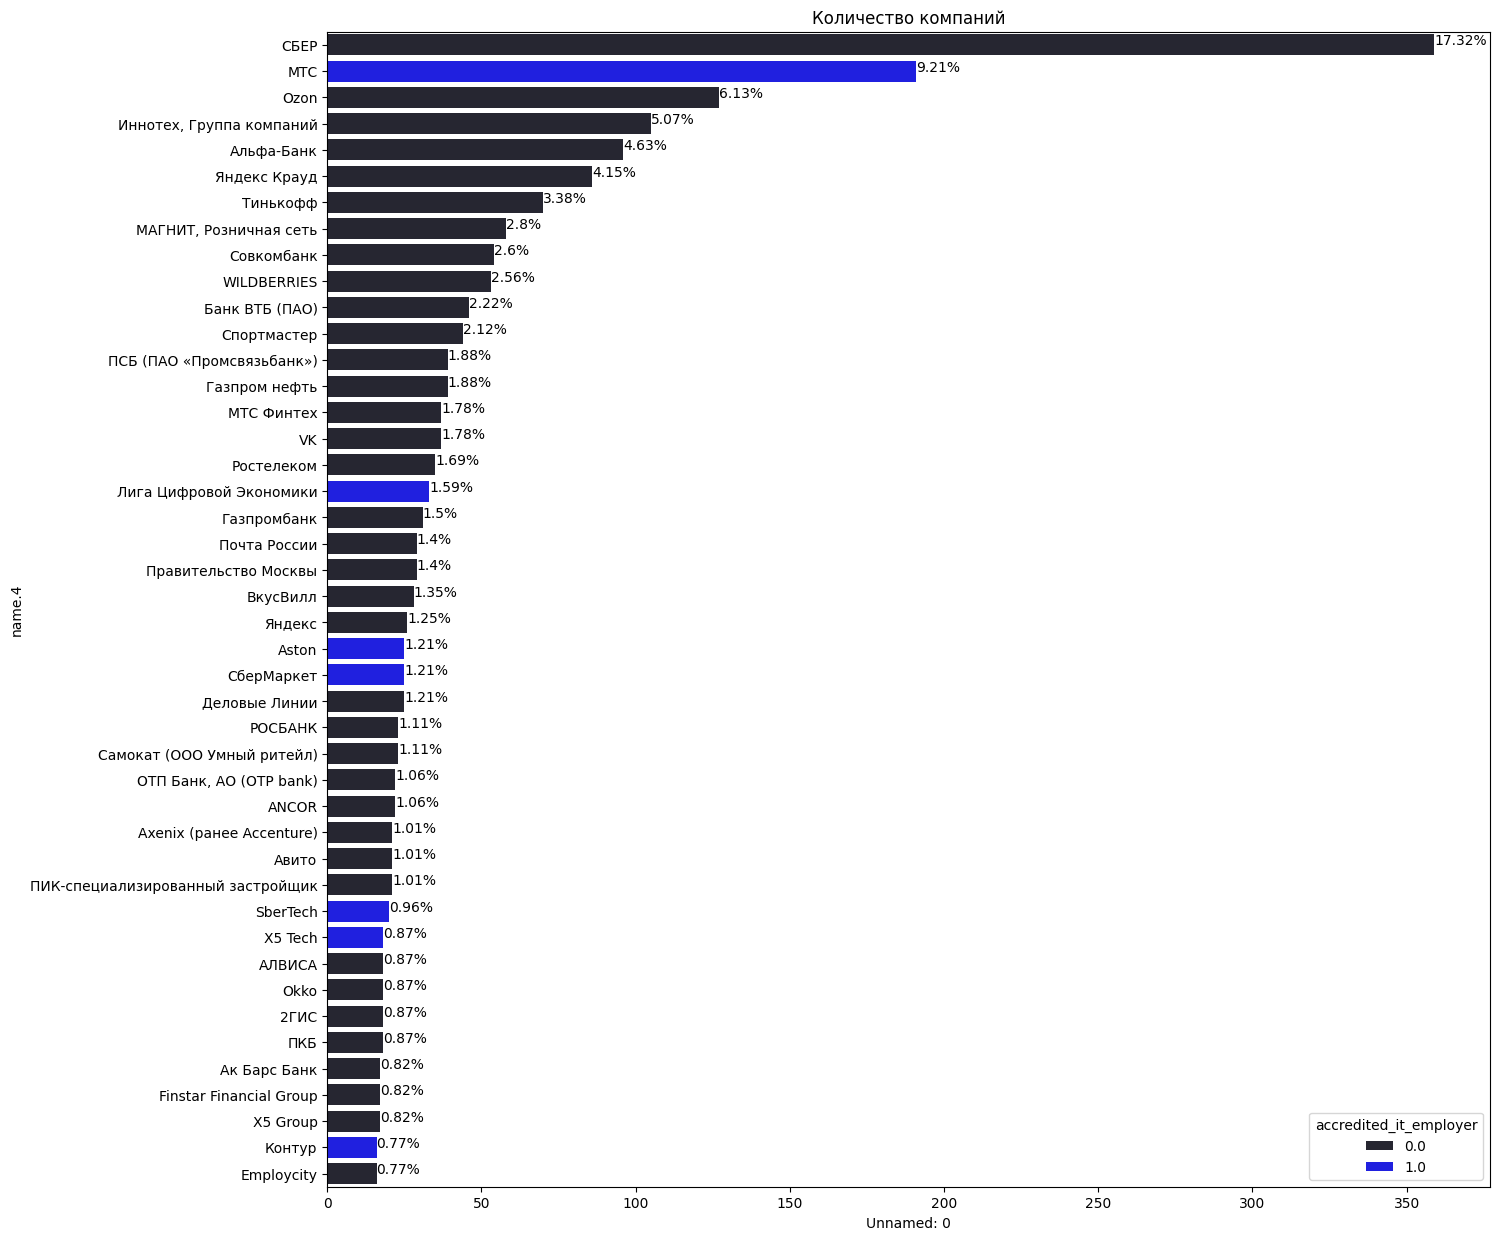

In [16]:
temp = data.groupby(['name.4'], as_index=False).count().iloc[:,:2]
temp = temp.sort_values(by='Unnamed: 0',ascending=False)
temp = pd.merge(temp, data[['name.4', 'accredited_it_employer']].drop_duplicates(), on='name.4', how='inner')

t = temp.groupby('accredited_it_employer', as_index=False).sum()
for i in range(2):
  employer = "Аккредитованный ит-" if t.values[i][0] else 'Обычный '
  print(employer + f"работодатель предоставляет {np.round(t.values[i][1] / temp['Unnamed: 0'].sum()*100, 2)} % вакансий")

temp = temp[temp['Unnamed: 0']>15]
temp.reset_index(drop=True, inplace=True)

plt.figure(figsize=(15,15))
sns.barplot(data=temp, x='Unnamed: 0', y='name.4', orient='h', color="b", hue='accredited_it_employer')
n = 0
for obs in range(temp.shape[0]):
  plt.annotate(str(np.round(temp.loc[obs, 'Unnamed: 0']/temp['Unnamed: 0'].sum()*100, 2))+'%', xy =(temp.loc[obs, 'Unnamed: 0'], obs))
  if obs<=9:
    n+=np.round(temp.loc[obs, 'Unnamed: 0']/temp['Unnamed: 0'].sum()*100, 2)

plt.title("Количество компаний")
plt.show()

В первой десятке работодателей обнаружены самые крупные компании РФ, причём к сфере IT относится только МТС. Эти 10 компаний предлагают 57.85% всех вакансий за рассматриваемый временной период. Остальные 1722 предлагают оставшиеся 42.15%  вакансий. </br></br>
Больше всего людей набирает к себе СБЕР - 17.32% всех вакансий принадлежит ему.

## География вакансий

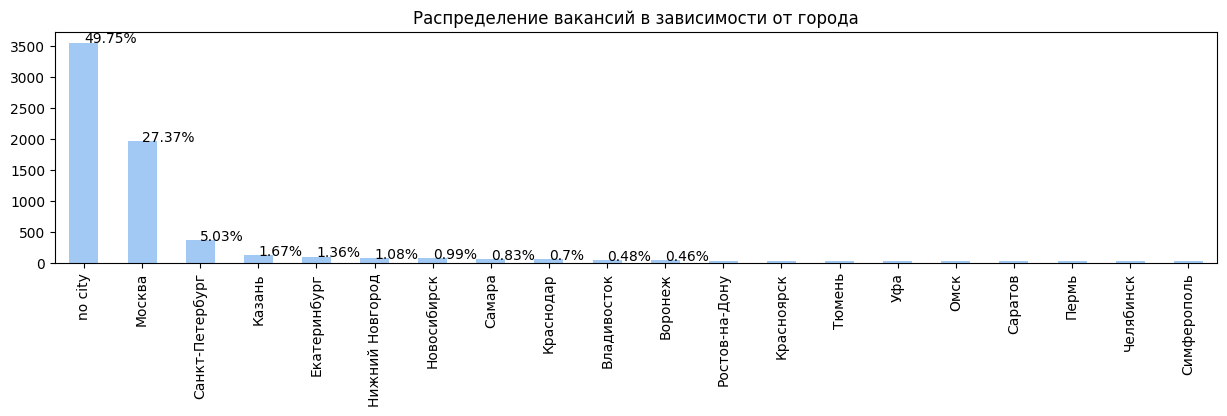

In [17]:
data.city.fillna('no city', inplace=True)
temp = data.city.value_counts()[:20]
temp.plot(kind='bar', figsize=(15,3))

for obs in range(11):
  plt.annotate(str(np.round(temp[obs]/data.shape[0]*100,2))+'%', xy =(obs, temp[obs]))

plt.title('Распределение вакансий в зависимости от города')
plt.show()

Мы видим очень много вакансий без указания города работы. Можно заметить, что 50% вакансий выставилось без указания города работы. 32.3% вакансий - в крупных городах России. Все остальные вакансии поделены между городами-миллиониками. </br></br>
Хотелось бы подробнее изучить географию вакансий.

In [18]:
gdf = gpd.GeoDataFrame(data[['name', 'city', 'currency']], geometry=gpd.points_from_xy(data.lng, data.lat))
gdf.drop([*data[data.lng.isna()].index, *data[data.lng == 0].index], inplace=True)

gdf_rur = gdf[gdf['currency']=='RUR']
gdf_foreing = gdf[gdf['currency']!='RUR']

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

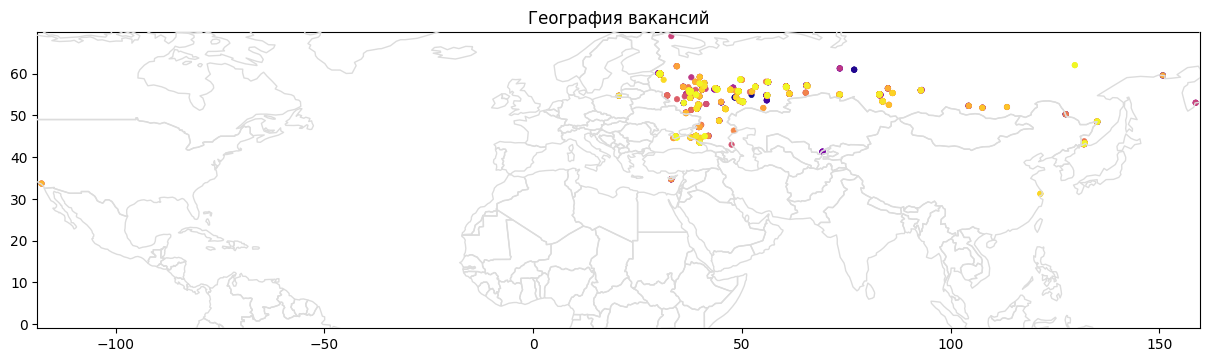

In [19]:
ax = world.plot(figsize=(15,15), color='none', edgecolor='gainsboro', zorder=3)

gdf.plot(linewidth=0.5, cmap='plasma', legend=True, markersize=15, ax=ax)
plt.title('География вакансий')

plt.xlim([data.lng.min()-1, data.lng.max()+1])
plt.ylim([data.lat.min()-1, data.lat.max()+1])
plt.show()


Пул вакансий включает в себя разнообразные города России, но также встречаются вакансии, выложеные и в Калифорнии, и в Китае. Что удивительно, ведь hh.ru -  рекрутинговая платформа России.

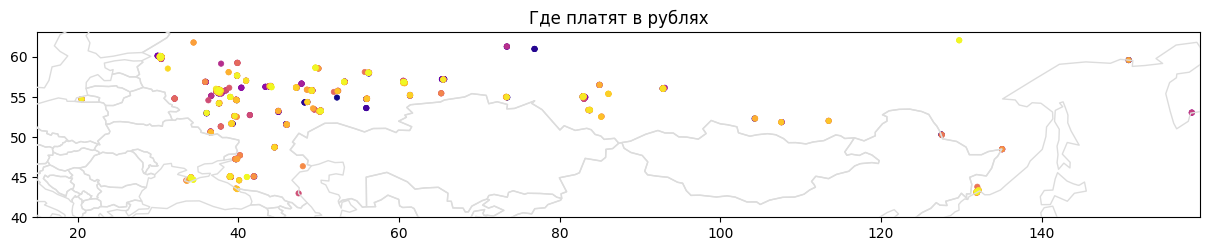

In [20]:
ax = world.plot(figsize=(15,15), color='none', edgecolor='gainsboro', zorder=3)

gdf_rur.plot(linewidth=0.5, cmap='plasma', legend=True, markersize=15, ax=ax)
plt.title('Где платят в рублях')

plt.xlim([15, data[data['currency']=='RUR'].lng.max()+1])
plt.ylim([40, data[data['currency']=='RUR'].lat.max()+1])

plt.show()

Вакансии с зарплатой в рублях предлагают толькона територии РФ.

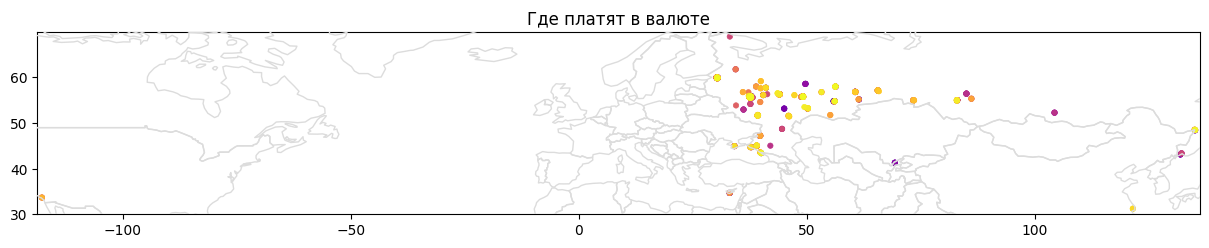

In [21]:
ax = world.plot(figsize=(15,15), color='none', edgecolor='gainsboro', zorder=3)

gdf_foreing.plot(linewidth=0.5, cmap='plasma', legend=True, markersize=15, ax=ax)
plt.title('Где платят в валюте')

plt.xlim([data[data['currency']!='RUR'].lng.min()-1,
          data[data['currency']!='RUR'].lng.max()+1])

plt.ylim([30,
          data[data['currency']!='RUR'].lat.max()+1])
plt.show()

А вот для вакансий с зарплатой в валюте дела обстоят интересней. Помимо того, что в датасет попали вакансии из ближнего и дальнего зарубежья, так ещё и в некоторых городах России зарплатная вилка указана в валюте (доллары и евро).

# Анализ требований к вакансиям

In [22]:
import spacy # общий пакет, где лежит весь функционал
from spacy.lang.ru .stop_words import STOP_WORDS # стоп слова

import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

import string # пунктуация
import plotly.express as px

from collections import Counter # для подсчёта слов

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [23]:
# требования к знаниям дата аналитика в зависимости от опыта работы
list_of_index = [r for r in range(data.shape[0]) if 'Аналитик данных' or 'data analyst' in data[data.name.notna()].name[r]]
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")

In [24]:
def text_processor(list_of_index, words_threshold=50):

  text = data.loc[list_of_index, 'requirement'].values

  # 0. При поверхностном изучении текста заметно, что выгрузка распарсилась с лишними  html-тегами.
  text = [i.replace('<highlighttext>', '').replace('</highlighttext>', '') for i in text if type(i)!=float]

  # 1. очистить от пунктуации и приводим всё к нижнему регистру
  tokens = [[w for w in  nltk.tokenize.TreebankWordTokenizer().tokenize(i.lower()) if w.isalpha()] for i in text]

  # 2. удаление стоп слов и пунктуации
  punctuations = string.punctuation
  tokens = [[token for token in i if token not in STOP_WORDS and token not in punctuations] for i in tokens]

  # 3. лемматизация
  lemmatizer = nltk.stem.WordNetLemmatizer()
  tokens = [[lemmatizer.lemmatize(token) for token in i if token != 'ml'] for i in tokens]

  # 4. подсчёт слов
  temp = pd.DataFrame.from_dict(Counter(sum(tokens, [])), orient='index')
  temp.reset_index(inplace=True)
  temp.columns = ['word', 'count']
  temp['per_count'] = [temp.loc[i, 'count']/temp['count'].sum()*100 for i in range(temp.shape[0])]
  temp.sort_values(by='count', ascending=False, inplace=True)

  # 5. визуализация
  plt.figure(figsize=(15,4))

  fig = px.treemap(temp[temp['count']>words_threshold], path=['word'], values='per_count',title='Tree Of Unique Positive Words')
  fig.show()

  plt.show()

In [25]:
words_thresholds=[50, 130, 100, 5]

for i in range(4):
  experience = data['name.6'].unique()[i]
  data_part = data[data['name.6']==experience]
  list_of_index = [r for r in range(data_part.shape[0]) if 'Аналитик данных' or 'data analyst' in data_part[data_part.name.notna()].name[r]]

  print(f'Анализ ключевых требований для опыта работы: {experience}')

  text_processor(list_of_index, words_threshold=words_thresholds[i])

Анализ ключевых требований для опыта работы: Нет опыта


<Figure size 1500x400 with 0 Axes>

Анализ ключевых требований для опыта работы: От 1 года до 3 лет


<Figure size 1500x400 with 0 Axes>

Анализ ключевых требований для опыта работы: От 3 до 6 лет


<Figure size 1500x400 with 0 Axes>

Анализ ключевых требований для опыта работы: Более 6 лет


<Figure size 1500x400 with 0 Axes>


Опыт работы

Для вакансий "без опыта" требование по наличию этого самого опыта упоминается в 6.4% вакансий - настолько же часто, как для вакансий "От 1 года до 3 лет"(6.8%) и "От 3 до 6 лет" (6.7%). Для вакансий с опытом работы "Более 6 лет" наличие опыта упоминается только в 4% случаях. Поскольку слово "работа" по частоте упоминания схоже со словом "опыт", то резонно предположить, что под словом "опыт" имеется ввиду именно "опыт работы", и реже, возможно, опыт практический. </br></br>



Hard skills

Навыки sql упоминаются примерно одинаково (около 1.5%). А вот навыки python варьируются от 0.8% до 1.2%. Навыки excel упоминаются на всех уровнях опыта работы, но только на вакансиях с требованием опыта "Более 6 лет" его упоминают в 2% случаев.

Упоминание bi инструментов есть на вакансиях "От 1 года до 3 лет" и "Более 6 лет". Умение работать с макросами (vba) упоминается в вакансиях с большим опытом работы (6+ лет и "От 1 года до 3 лет"). Также для вакансий "Более 6 лет" есть требование по знанию "oracle". </br></br>

Абстрактное

"Понимания" на всех уровнях вакансий требуется почти одинаково - около 1%. И только на вакансиях "Более 6 лет" понимания требуется вдвое меньше. Развитие и "желание" упоминается только для вакансий с большим опытом работы ("Более 6 лет").

Для категории "Более 6 лет" употребляется слово "обязательно". Из графика можно подумать, что это слово соотносится с наличием опыта работы в такой сфере, как "экономика".

# Выводы

Проанализировав спарсенный датасет, можно сделать следующие заключения:
- Через hh.ru  можно найти работу за рубежом.
- Большая часть вакансий - это "всепогодный" аналитик. Вакансий дата аналитиков в целом мало.
- Имеет смысл набираться опыта в столицах (Москва и СПб), поскольку зарплата там в среднем выше, чем в малых и крупных городах. По прошествии 6-ти лет работы можно перебираться в малый город - платить там опытному специалисту будут больше.
- Есть больший шанс найти работу в компании, которая не связана с IT индустрией. На текущий момент разница в зарплате в IT и в не-IT сферах смещена в сторону не-IT компаний - там в среднем платят больше.
- С большой вероятностью удастся найти работу в крупной и известной компании - они постят больше вакансий.
- Даже для вакансий, на которых помечено "без опыта", уже требуется опыт.
- Джентльменский набор дата аналитика не меняется: excel, python, sql, bi-интрументы.
